In [1]:
cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_min_both_pct_0.5/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_min_both_pct_0.5/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/top/scrap"

clone_order_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_min_both_pct_0.5/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/clones_ranked/representative_cloneID.txt"
ntop_clones = 10

#cloneID = "0_C6"

In [2]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})


plt.rcParams['svg.fonttype'] = 'none'

fig_utils from mplh
0.5.6


In [3]:
import seaborn as sns
from mplh import cluster_help as ch

In [4]:
clone_order = pd.read_csv(clone_order_f, header=None)[0].values
top_clones = clone_order[:ntop_clones]
top_clones

array(['0_5', '0_9', '0_35', '0_24', '0_31', '0_30'], dtype=object)

In [5]:
cells_meta = pd.read_csv(cells_meta_f,sep="\t", index_col=0)
cells_meta

,cloneID,clusterID,condition,donor
Flt3l_AACGGGACAGCAACAG-1,0_17,6,Flt3l,0
Flt3l_AACTGGTCACTACACA-1,0_28,4,Flt3l,0
Flt3l_AAGGTTCGTTACGGAG-1,0_32,1,Flt3l,0
Flt3l_AATACGCTCCAATCCC-1,0_21,1,Flt3l,0
Flt3l_AATGTCGAGAAGGGCG-1,0_9,3,Flt3l,0
...,...,...,...,...
Input_TTTGTGTCACACATTG-1,0_14,0,Input,0
Input_TTTGTGTGTAAGCCGA-1,0_21,0,Input,0
Input_TTTGTGTGTAGGGTCA-1,0_26,0,Input,0
Input_TTTGTGTTCCTGAAAC-1,0_27,7,Input,0


## Filter for clone

In [6]:
norm_condition = cells_meta.groupby("condition").size()
norm_condition

norm_lineage = cells_meta.groupby("clusterID").size()
norm_lineage

clusterID
0     617
1      44
2     362
3      46
4      13
5      51
6      43
7     132
8       7
9      14
10     56
11     64
dtype: int64

In [7]:
# for clone_id, curr_cells in cells_meta.groupby("cloneID"):
#     print(clone_id)

#     curr_dir = join(outdir, f"cloneID_{clone_id}")
#     if not exists(curr_dir):
#         os.mkdir(curr_dir)
        
#     f, ax = plt.subplots(figsize=(12,12), dpi=300)

#     curr_cells_group = curr_cells.groupby(["clusterID", "condition"]).size().reset_index().pivot(index="clusterID", columns="condition", values=0).fillna(0)
#     curr_cells_group.plot.bar(stacked=True, ax=ax)
#     plt.savefig(join(curr_dir, "cluster_condition_ncells.pdf"))
#     f, ax = plt.subplots(figsize=(12,12), dpi=300)
#     curr_cells_group_norm = curr_cells_group.apply(lambda x: x/norm_condition.loc[x.name], axis=0)
#     curr_cells_group_norm.plot.bar(stacked=True, ax=ax)
#     plt.savefig(join(curr_dir, "cluster_condition_ncells_norm.pdf"))
    
#     f, ax = plt.subplots(figsize=(12,12), dpi=300)
#     curr_cells_lineage_group = curr_cells.groupby(["clusterID", "condition"]).size().reset_index().pivot(columns="clusterID", index="condition", values=0).fillna(0)
#     curr_cells_group_norm = curr_cells_lineage_group.apply(lambda x: x/norm_lineage.loc[x.name], axis=0)
#     curr_cells_lineage_group.plot.bar(stacked=True, ax=ax)
#     plt.savefig(join(curr_dir, "cluster_lineage_splitCondition_ncells_norm.pdf"))
#     plt.close('all')

In [8]:
if "cloneID" not in cells_meta.columns:
    # cell can have multiple entries if contains multiple variants
    print("MT variants")
    cells_meta.columns = [x.replace("cloneID_", "") for x in cells_meta.columns]
    cells_meta = cells_meta.reset_index().melt(id_vars=["index", "donor", "clusterID", "condition"], 
                                               value_name="inClust", var_name="cloneID")
    cells_meta = cells_meta[cells_meta["inClust"]==1]
    top_cells_meta = cells_meta[cells_meta["cloneID"].isin(top_clones)]
    top_cells_meta
else:
    top_cells_meta = cells_meta[cells_meta["cloneID"].isin(top_clones)]
top_cells_meta

# top_cells_meta = cells_meta[cells_meta["cloneID"].isin(top_clones)]
# top_cells_meta

,cloneID,clusterID,condition,donor
Flt3l_AATGTCGAGAAGGGCG-1,0_9,3,Flt3l,0
Flt3l_ACAGCGCTCCAGGGAA-1,0_30,4,Flt3l,0
Flt3l_AGTCCGGGTGGTGGTA-1,0_31,4,Flt3l,0
Flt3l_AGTGCGCTCTTCAGAG-1,0_30,1,Flt3l,0
Flt3l_ATAGGCTGTACAAGCG-1,0_31,3,Flt3l,0
...,...,...,...,...
Input_TTTGGCCAGATCGATA-1,0_31,0,Input,0
Input_TTTGGTTCATGGCCCA-1,0_9,2,Input,0
Input_TTTGGTTTCACTCGGG-1,0_9,2,Input,0
Input_TTTGGTTTCGGGAAAC-1,0_5,0,Input,0


In [9]:
# Get color map for the conditions. Needed to keep consistency across clones
conds = top_cells_meta["condition" ].unique()
colors = list(sns.color_palette("muted", len(conds)))
color_map = {val: colors[ind] for ind, val in enumerate(conds)}
color_map

{'Flt3l': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 'Input': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726)}

In [10]:
def plot_bar(data, **kwargs):
    f_df = data.pivot(index="clusterID", columns="condition", values=0).fillna(0)
    f_df.plot.bar(stacked=True, ax=plt.gca(), color=color_map)
    return

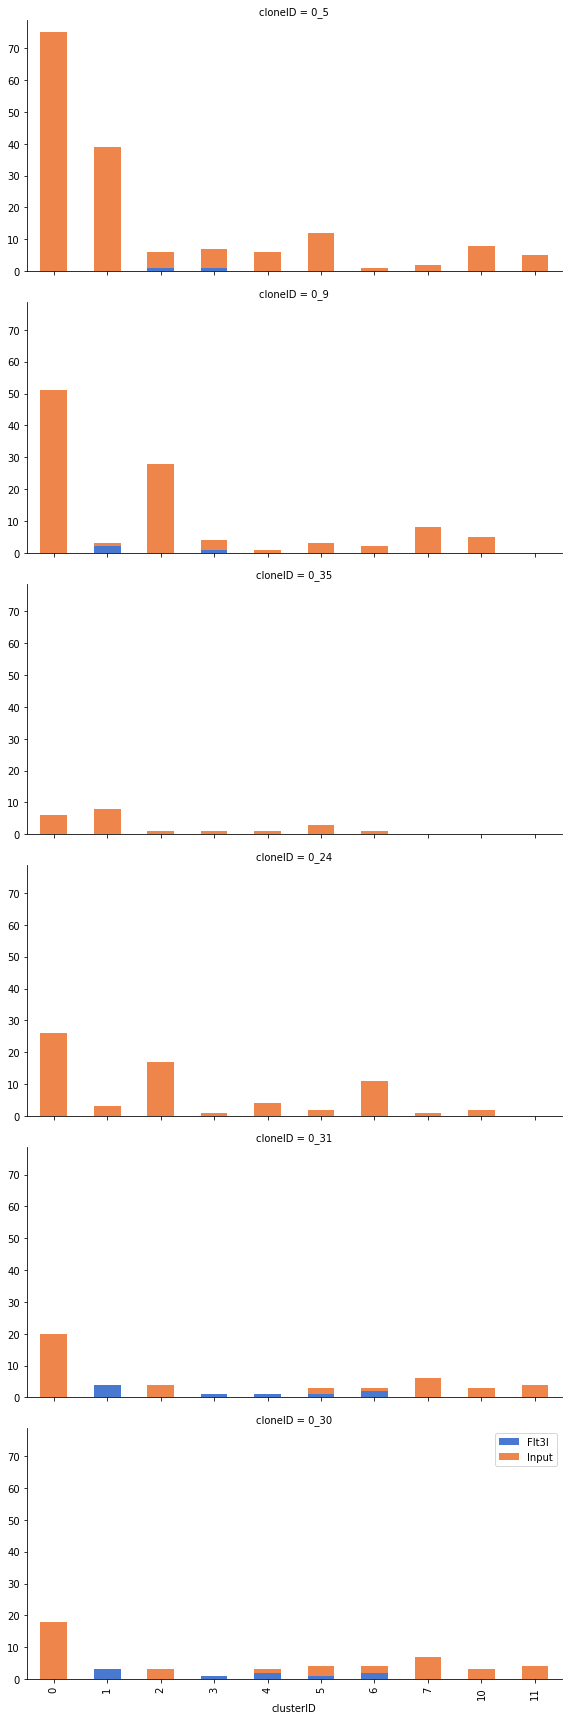

In [11]:
curr_cells_group = top_cells_meta.groupby(["clusterID", "cloneID", "condition"]).size().reset_index()


g = sns.FacetGrid(data=curr_cells_group, col="cloneID", col_order=top_clones, 
                  col_wrap=1, height=4, aspect=2)

g.map_dataframe(plot_bar, axis=1)

#              height=4*top_clones, width=2*4*top_clones
#.pivot(index="clusterID", columns="condition", values=0).fillna(0)
# curr_cells_group.plot.bar(stacked=True, ax=ax)
plt.legend(loc='best')
g.fig.savefig(fname=join(outdir, f"top_cluster_condition_ncells.svg"), dpi=500, bbox_inches='tight', pad_inches=0.5)
g.fig.savefig(fname=join(outdir, f"top_cluster_condition_ncells.pdf"), dpi=500, bbox_inches='tight', pad_inches=0.5)
